In [40]:
import os
import requests
import zipfile
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

In [41]:
# https://github.com/cvdfoundation/mnist?tab=readme-ov-file
DATA_DIR = "/app/dataset/MNIST"
os.makedirs(DATA_DIR, exist_ok=True)

In [42]:
import gzip
import shutil


def download_mnist():
    MNIST_FILES = {
    "train_images": "https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz",
    "train_labels": "https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz",
    "test_images":  "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz",
    "test_labels":  "https://storage.googleapis.com/cvdf-datasets/mnist/t10k-labels-idx1-ubyte.gz",
    }
    for name, url in MNIST_FILES.items():
        out_path = os.path.join(DATA_DIR, url.split('/')[-1])
        result_path = out_path[:-3] 
        if not os.path.exists(result_path):
            if not os.path.exists(out_path):
                print(f"Downloading {name}...")
                r = requests.get(url)
                with open(out_path, 'wb') as f:
                    f.write(r.content)
            else:
                print(f"{name} already downloaded.")
            print(f"Unzipping {out_path}...")
            with gzip.open(out_path, 'rb') as f_in:
                with open(result_path, 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
        
        else:
            print(f"{name} already unzipped.")

In [43]:
download_mnist()

train_images already unzipped.
train_labels already unzipped.
test_images already unzipped.
test_labels already unzipped.


In [44]:
def loadMNIST( prefix, folder ):
    intType = np.dtype( 'int32' ).newbyteorder( '>' )
    nMetaDataBytes = 4 * intType.itemsize

    data = np.fromfile( folder + "/" + prefix + '-images-idx3-ubyte', dtype = 'ubyte' )
    print(folder + "/" + prefix + '-images-idx3-ubyte')
    magicBytes, nImages, width, height = np.frombuffer( data[:nMetaDataBytes].tobytes(), intType )
    data = data[nMetaDataBytes:].astype( dtype = 'float32' ).reshape( [ nImages, width, height ] )

    labels = np.fromfile( folder + "/" + prefix + '-labels-idx1-ubyte',
                          dtype = 'ubyte' )[2 * intType.itemsize:]

    return data, labels

trainingImages, trainingLabels = loadMNIST( "train", "/app/dataset/MNIST" )
testImages, testLabels = loadMNIST( "t10k", "/app/dataset/MNIST" )

/app/dataset/MNIST/train-images-idx3-ubyte
/app/dataset/MNIST/t10k-images-idx3-ubyte


In [45]:
def toHotEncoding( classification ):
    # emulates the functionality of tf.keras.utils.to_categorical( y )
    classification = classification.astype(int)  # Ensure integer class labels
    num_samples = classification.shape[0]
    num_classes = np.max(classification) + 1
    hotEncoding = np.zeros((num_samples, num_classes), dtype=np.float32)
    hotEncoding[np.arange(num_samples), classification] = 1
    return hotEncoding


In [46]:
X_train = trainingImages / 255.0
X_train = X_train.reshape(X_train.shape[0], -1)

X_test = testImages / 255.0
X_test = X_test.reshape(X_test.shape[0], -1)


y_train = toHotEncoding( trainingLabels )
y_test = toHotEncoding( testLabels )

print(f"{X_train.shape}:{y_train.shape}")

(60000, 784):(60000, 10)


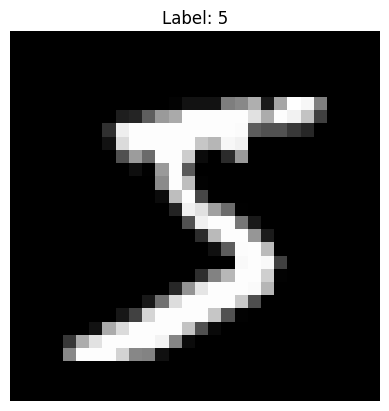

In [47]:
i = 0

image = trainingImages[i]  
label = trainingLabels[i]

plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [48]:

# https://datascience.stackexchange.com/questions/75855/what-types-of-matrix-multiplication-are-used-in-machine-learning-when-are-they
# I wanna be able to stack layers
# idea is if tthis get passed to antoher then it will build the neural net
# build weight matrix
# get frontprop calc to work

def softmax(x):
    exps = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exps / np.sum(exps, axis=-1, keepdims=True)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0).astype(np.float64)

def sigmoid(x):
    return np.where(
        x >= 0,
        1 / (1 + np.exp(-x)),
        np.exp(x) / (1 + np.exp(x))
    )

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    dx = np.ones_like(x)
    dx[x < 0] = alpha
    return dx

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x) ** 2

def binary_cross_entropy(y_pred, y_true, epsilon=1e-12):
    y_pred = np.clip(y_pred, epsilon, 1. - epsilon)
    loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return np.mean(loss)


def categorical_cross_entropy(y_pred, y_true,  epsilon=1e-8):
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
    return loss

activation_map = {
    'sigmoid': (sigmoid, sigmoid_derivative),
    'relu': (relu, relu_derivative),
    'tanh': (tanh, tanh_derivative),
    None: (lambda x: x, lambda x: np.ones_like(x))  # No activation
}

class LinearLayer():
    def __init__(self, inFeature, outFeature, activationFunction=None) -> None:
        self.W = (np.random.randn(inFeature, outFeature) * np.sqrt(2 / (inFeature + outFeature))).astype(np.float64)
        self.b = np.zeros((1, outFeature), dtype=np.float64)
        self.trainable = True
        self.activation, self.activation_deriv = activation_map.get(activationFunction, (None, None))
        self.y = self.z = self.X = None

    def Forward(self, X):
        self.X = X
        self.z = X @ self.W + self.b
        self.y = self.activation(self.z)
        return self.y

    def BackwardHidden(self, dEdy, lr=0.01):
        dydx = self.activation_deriv(self.z)
        dEdx = dEdy * dydx
        dEdW = self.X.T @ dEdx
        dEdb = np.sum(dEdx, axis=0, keepdims=True)
        
        if self.trainable:
            self.W -= lr * dEdW
            self.b -= lr * dEdb

        return dEdx @ self.W.T

class Model():
    def __init__(self, layers) -> None:
        self.layers = layers

    def ForwardProp(self, X):
        for layer in self.layers:
            X = layer.Forward(X)
        return X

    def BackwardProp(self, dEdy, learningRate=0.01):
        for layer in reversed(self.layers):
            dEdy = layer.BackwardHidden(dEdy, lr=learningRate)
        
    def train(self, epochs, X_train, y_train, loss_fn, metrics_fn, learningRate=0.01, X_test=None, y_test=None):
        train_loss=[]
        train_metrics=[]
        test_loss=[]
        test_metrics=[]
        for epoch in range(epochs):
            logits = self.ForwardProp(X_train)
            probs = softmax(logits)
            loss = loss_fn(probs, y_train)
            metrics = metrics_fn(probs, y_train)
            train_loss.append(loss)
            train_metrics.append(metrics)
            # Gradient of softmax + categorical crossentropy
            dEdy = (probs - y_train) / y_train.shape[0]
            self.BackwardProp(dEdy, learningRate)

            if X_test.shape and y_test.shape is not None:
                test_logits = self.ForwardProp(X_test)
                test_probs = softmax(test_logits)
                test_loss_value = loss_fn(test_probs, y_test)
                test_metrics_value = metrics_fn(test_probs, y_test)
                test_loss.append(test_loss_value)
                test_metrics.append(test_metrics_value)
                print(f"Epoch: {epoch}, Loss: {loss:.4f}, Acc: {metrics:.4f}, Test Loss: {test_loss_value:.4f}, Test Acc: {test_metrics_value:.4f},")
            else:
                print(f"Epoch: {epoch}, Loss: {loss:.4f}, Acc: {metrics:.4f}")
                
        return {"train_loss": train_loss,
             "train_metrics": train_metrics,
             "test_loss": test_loss,
             "test_metrics": test_metrics}

def toHotEncoding( classification ):
    # emulates the functionality of tf.keras.utils.to_categorical( y )
    classification = classification.astype(int)  # Ensure integer class labels
    num_samples = classification.shape[0]
    num_classes = np.max(classification) + 1
    hotEncoding = np.zeros((num_samples, num_classes), dtype=np.float32)
    hotEncoding[np.arange(num_samples), classification] = 1
    return hotEncoding

def accuracy(y_pred, y_true):
    # Get predicted class indicesa
    pred_labels = np.argmax(y_pred, axis=1)
    
    # Convert one-hot to class indices if needed
    if y_true.ndim == 2:
        true_labels = np.argmax(y_true, axis=1)
    else:
        true_labels = y_true

    correct = np.sum(pred_labels == true_labels)
    total = y_true.shape[0]
    return correct / total

def plot_decision_boundary(model, X, y, resolution=0.01):
    # Set min and max values for the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    # Generate a mesh grid
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, resolution),
        np.arange(y_min, y_max, resolution)
    )
    
    # Flatten grid and stack as input
    grid = np.c_[xx.ravel(), yy.ravel()]
    
    # Predict using the model
    logits = model.ForwardProp(grid)
    probs = softmax(logits)
    
    predictions = np.argmax(probs, axis=1)
    
    # Reshape to match grid
    zz = predictions.reshape(xx.shape)

    # Plot decision regions
    plt.contourf(xx, yy, zz, alpha=0.5, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=np.argmax(y, axis=1), s=30, edgecolor='k', cmap=plt.cm.coolwarm)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary")
    plt.show()

In [49]:
layerSequence = [
    LinearLayer(inFeature=784, outFeature=64,activationFunction="relu"),
    LinearLayer(inFeature=64, outFeature=64, activationFunction="relu"),
    LinearLayer(inFeature=64, outFeature=10,activationFunction=None)  # final logits (softmax applied outside)
]
model=Model(layerSequence)

In [50]:
i = 3
image = trainingImages[i].reshape(1, -1) / 255.0  
label = trainingLabels[i]
y_logits = model.ForwardProp(image)
y_pred = softmax(y_logits)

predicted_class = np.argmax(y_pred)

print(f"True label: {label}, Predicted label: {predicted_class}")

True label: 1, Predicted label: 4


In [51]:
y_pred

array([[0.10885402, 0.06467855, 0.12570387, 0.08879032, 0.13834669,
        0.11325668, 0.09888067, 0.09754801, 0.07346605, 0.09047513]])

In [52]:

epochs=100

metrics=model.train(epochs=100, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, loss_fn=categorical_cross_entropy, metrics_fn=accuracy, learningRate=0.01)
losses=metrics["train_loss"]

Epoch: 0, Loss: 2.3877, Acc: 0.0819, Test Loss: 2.3857, Test Acc: 0.0829,
Epoch: 1, Loss: 2.3809, Acc: 0.0821, Test Loss: 2.3790, Test Acc: 0.0846,
Epoch: 2, Loss: 2.3744, Acc: 0.0831, Test Loss: 2.3725, Test Acc: 0.0859,
Epoch: 3, Loss: 2.3682, Acc: 0.0837, Test Loss: 2.3663, Test Acc: 0.0869,
Epoch: 4, Loss: 2.3622, Acc: 0.0847, Test Loss: 2.3603, Test Acc: 0.0872,
Epoch: 5, Loss: 2.3564, Acc: 0.0855, Test Loss: 2.3545, Test Acc: 0.0881,
Epoch: 6, Loss: 2.3508, Acc: 0.0867, Test Loss: 2.3488, Test Acc: 0.0894,
Epoch: 7, Loss: 2.3454, Acc: 0.0877, Test Loss: 2.3434, Test Acc: 0.0896,
Epoch: 8, Loss: 2.3401, Acc: 0.0889, Test Loss: 2.3381, Test Acc: 0.0911,
Epoch: 9, Loss: 2.3350, Acc: 0.0897, Test Loss: 2.3329, Test Acc: 0.0926,
Epoch: 10, Loss: 2.3301, Acc: 0.0909, Test Loss: 2.3279, Test Acc: 0.0950,
Epoch: 11, Loss: 2.3253, Acc: 0.0921, Test Loss: 2.3230, Test Acc: 0.0964,
Epoch: 12, Loss: 2.3205, Acc: 0.0937, Test Loss: 2.3182, Test Acc: 0.1005,
Epoch: 13, Loss: 2.3159, Acc: 0.095

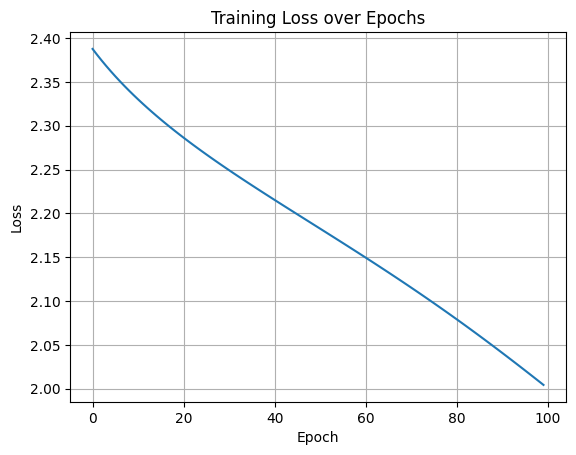

In [53]:
plt.plot(losses)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

True label: 4, Predicted label: 2


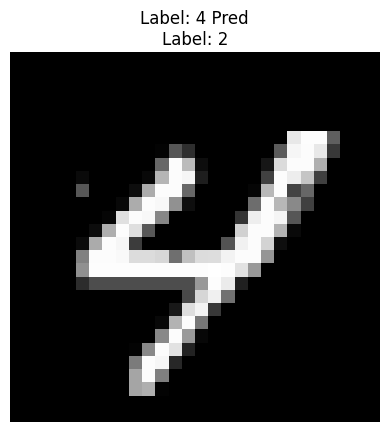

In [ ]:
import random
i = random.randint(0,400)
image_raw=trainingImages[i]
image = trainingImages[i].reshape(1, -1) / 255.0  
label = trainingLabels[i]
y_logits = model.ForwardProp(image)
y_pred = softmax(y_logits)



predicted_class = np.argmax(y_pred)

print(f"True label: {label}, Predicted label: {predicted_class}")
plt.imshow(image_raw, cmap='gray')
plt.title(f"Label: {label} \nPredLabel: {predicted_class}")
plt.axis('off')
plt.show()